In [77]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {}'.format(device))
torch.device(device)

Using cuda


device(type='cuda')

In [79]:
#training variables

imgTransformSize = 224
#range of degrees +- to rotate
imgTransformRngRot = 5

train_dataset_path = './datasets/FoodTrain1'
test_dataset_path = './datasets/FoodValidate1'

In [80]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(scale=(0.6, 1.0), size=(imgTransformSize,imgTransformSize)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(imgTransformRngRot),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(imgTransformSize,imgTransformSize)),
    transforms.ToTensor()
])

In [81]:
train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform = test_transforms)

In [82]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels: ', labels)

labels:  tensor([27, 13, 16, 19, 35, 13])


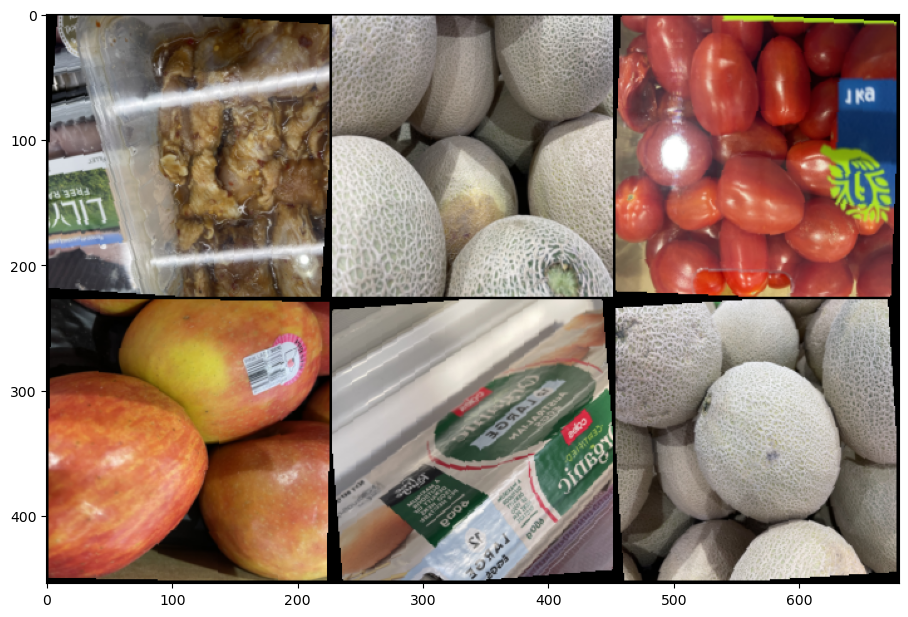

In [83]:
show_transformed_images(train_dataset)

In [84]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle = False)


In [85]:
train_losses, test_losses = [], []
train_accs, test_accs = [], []
epoch_test_accuracy, epoch_test_loss = 0, 0

def train_network(model, train_loader, test_loader, criterion, optimiser, n_epochs):
    for epoch in range(n_epochs):
        print("Epoch number %d (epoch + 1)")
        model.train()
        epoch_loss, epoch_accuracy = 0, 0
        totalImg = 0

        for data in train_loader:
            image, label = data
            image = image.to(device)
            label = label.to(device)

            optimiser.zero_grad()

            output = model(image)

            _, predictions = torch.max(output.data, 1)

            loss = criterion(output, label)
            loss.backward()

            optimiser.step

            acc = ((output.argmax(dim=1) == label).float().mean())

            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        print('Epoch: {}, train accuracy: {:.2f}%, train loss: {:.4f}'.format(epoch+1, epoch_accuracy*100, epoch_loss))
        train_losses.append(epoch_loss.item())
        train_accs.append(epoch_accuracy.item())



In [86]:
def evaluate_network(model, test_loader):
    # Switch model to evaluation (affects batch norm and dropout)
    model.eval()
    # Disable gradients
    with torch.no_grad():
        # Iterate through batches
        for data, label in test_loader:
            # Move data to the used device
            data = data.to(device)
            label = label.to(device)
            # Forward pass
            test_output = model(data)
            test_loss = criterion(test_output, label)
            # Compute metrics
            acc = ((test_output.argmax(dim=1) == label).float().mean())
            epoch_test_accuracy += acc/len(test_loader)
            epoch_test_loss += test_loss/len(test_loader) 
    print('Epoch: {}, test accuracy: {:.2f}%, test loss: {:.4f}'.format(epoch+1, epoch_test_accuracy*100, epoch_test_loss))
    test_losses.append(epoch_test_loss.item())
    test_losses.append(epoch_test_accuracy.item())

In [87]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(weights= False)

num_features = resnet18_model.fc.in_features
num_object_categories = 40 

resnet18_model.fc = nn.Linear(num_features, num_object_categories)
resnet18_model = resnet18_model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimiser = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_network(resnet18_model, train_loader, test_loader, loss_fn, optimiser, 150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True)
ax1.plot(train_losses, color='b', label='train')
ax1.plot(test_losses, color='g', label='valid')
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(train_accs, color='b', label='train')
ax2.plot(test_accs, color='g', label='valid')
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.legend()

In [ ]:
test_accuracy, test_loss = 0, 0
with torch.no_grad():
    # Iterate through batches
    for data, label in test_loader:
        # Move data to the used device
        data = data.to(device)
        label = label.to(device)
        # Forward pass
        test_output_i = model(data)
        test_loss_i = loss_fn(test_output_i, label)
        # Compute metrics
        acc = ((test_output_i.argmax(dim=1) == label).float().mean())
        test_accuracy += acc/len(test_loader)
        test_loss += test_loss_i/len(test_loader)

print("Test loss: {:.4f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(test_accuracy*100))